In [1]:
%matplotlib inline

In [2]:
import sys
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Literal, Optional
from pathlib import Path

In [3]:
current_dir = Path.cwd()
project_root = current_dir.parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))
    print('done')

done


In [4]:
from src.utils.save_data import save_df_parquet_safe, load_df_parquet_safe
from src.utils.plot_graphs import plot_beautiful, plot_dual_beautiful

In [5]:
path = project_root / "data" / "processed" / "merge" / "avw_merged_2.parquet"
avw_data = load_df_parquet_safe(path=str(path))
avw_data_copy = avw_data.copy()
avw_data_copy.head()

,Time,words,text_concat,h_ratio,v_ratio,_neutral,browDownLeft,browDownRight,browInnerUp,browOuterUpLeft,...,mouthUpperUpRight,noseSneerLeft,noseSneerRight,audio_rms(volumn),audio_pitch_avg,audio_pitch_var(expressiveness),is_silent,speaker,filler_percentage,pause_percent_pr
0,0.0,"[We're, starting]",We're starting,0.463844,0.012997,3.112116e-06,0.015592,0.025971,0.023290,0.123947,...,0.000022,4.540787e-07,4.185384e-07,0.0373,0.00,0.00,False,None,0.064433,0.079177
1,0.5,"[now., [*]]",now. [*],0.418074,-0.048988,2.558370e-06,0.017408,0.037184,0.007811,0.137800,...,0.000030,2.511999e-07,3.643879e-07,0.0533,169.25,11.45,False,A,0.064433,0.079177
2,1.0,None,,0.465044,-0.030748,3.958608e-07,0.008864,0.010406,0.016732,0.179330,...,0.000269,2.899701e-06,1.134860e-07,0.0006,0.00,0.00,True,A,0.064433,0.079177
3,1.5,"[So, welcome]",So welcome,0.505119,-0.055033,3.260218e-07,0.012983,0.016629,0.008106,0.186212,...,0.000103,2.350217e-06,9.529118e-08,0.0593,179.94,14.03,False,A,0.064433,0.079177
4,2.0,"[to, the]",to the,0.590369,-0.050514,5.068692e-07,0.016363,0.028436,0.006705,0.117622,...,0.000476,4.304491e-06,2.317813e-07,0.0646,237.84,56.17,False,A,0.064433,0.079177


In [6]:
def secs_mins(secs):
    mins = secs / 60
    if mins < 1:
        return mins*60
    else:
        sec = (mins - (secs // 60))*60
        mins = str(int((secs // 60))) + ":" + str(round(sec))
        return mins

#### Have Tested 2-3 models this model which is called RRCF (Robust Random Cut Forest) has worked well, basically i wanted a model that is unsupervised (since i don't have any labels 😅) Anomaly Detection ML algo and i also wanted a model that consider the temporal characteristic of the data, So, I wanted a model that would work better on Time Series Anomaly Detection, and this looks promising.

In [7]:
from pysad.models import RobustRandomCutForest
from pysad.utils import ArrayStreamer
from sklearn.preprocessing import StandardScaler

In [8]:
def run_rrcf(features: np.ndarray, num_trees: int = 40, tree_size: int = 256, shingle: int = 1):
    """Runs rrcf on the given features

    Args:
        features (np.ndarray): provide your features as numpy nd array in shape (num_samples, num_features)
        num_trees (int, optional): No of trees the model should fit. Defaults to 40.
        tree_size (int, optional): max depth of the tree. Defaults to 256.
        shingle (int, optional): _description_. Defaults to 1.

    Returns:
        list: returns list of anomaly which is equal to the length of the feature array.
    """
    # initializing the model
    model = RobustRandomCutForest(num_trees=num_trees, tree_size=tree_size, shingle_size=shingle)
    
    # This simulates a live stream from a static array
    streamer = ArrayStreamer(shuffle=False)
    
    anomaly_scores = []
    
    for X in streamer.iter(features):
        # fit_score_partial updates the model and returns the score in one step
        score = model.fit_score_partial(X)
        anomaly_scores.append(score)
    
    print(f"Processed {len(anomaly_scores)} points")
    
    return anomaly_scores

In [9]:
def adaptive_n_sigma(anomaly_scores: np.ndarray) -> float:
    """
    Automatically determine optimal n_sigma based on score distribution
    
    Returns:
        Optimal n_sigma value (typically 2.5 - 4.5)
    """
    from scipy import stats as scipy_stats
    
    # Calculate distribution characteristics
    skewness = scipy_stats.skew(anomaly_scores)
    kurtosis = scipy_stats.kurtosis(anomaly_scores)
    
    # Decision rules
    if kurtosis > 5:
        # Heavy tails (extreme outliers)
        n_sigma = 4.0
    elif kurtosis > 3:
        # Moderately heavy tails
        n_sigma = 3.5
    elif skewness > 1.5:
        # Strong right skew (occasional high scores)
        n_sigma = 3.5
    elif skewness > 1.0:
        # Moderate right skew
        n_sigma = 3.0
    else:
        # Normal-ish distribution
        n_sigma = 2.5
    
    return n_sigma

In [10]:
def get_threshold_mad(scores, n_sigma=3):
    """
    Robust Z-Score method using Median and MAD.
    Standard Z-Score = (x - mean) / std
    Robust Z-Score = (x - median) / (1.4826 * MAD)
    """
    scores = np.array(scores)
    median = np.median(scores)
    
    # Calculate MAD (Median Absolute Deviation)
    mad = np.median(np.abs(scores - median))
    
    # The factor 1.4826 makes MAD comparable to Standard Deviation for normal data
    consistent_mad = 1.4826 * mad
    
    # Threshold = Median + (3 * Robust_Std_Dev)
    threshold = median + (n_sigma * consistent_mad)
    return threshold

In [11]:
def get_data_ready(data: pd.DataFrame, features: list[str], type: Literal["ui", "ud"], standardize: bool, scalar: Optional[StandardScaler] = None):
    """Data get's ready to be processed.

    Args:
        scalar (StandardScaler): needed to standardize the data
        data (pd.DataFrame): need the complete data
        features (list[str]): Just provide a list of feature names that you want to fit with model
        type (Literal[&quot;ui&quot;, &quot;ud&quot;]): 'ui' if the user independent else 'ud' user dependent
    """
    
    # get the data
    if type == 'ui':
        features = data[features].ffill()
        f_id = features.index
        if standardize:
            features = scalar.fit_transform(features)
            return f_id, features
        else:
            return f_id, features.to_numpy()
    else:
        features = data.loc[data['speaker'] == 'B', features]
        if features.notna().all().all():
            f_id = features.index
            if standardize:
                features = scalar.fit_transform(features)
                return f_id, features
            else:
                return f_id, features.to_numpy()
        else:
            features = features.ffill()
            f_id = features.index
            if standardize:
                features = scalar.fit_transform(features)
                return f_id, features
            else:
                return f_id, features.to_numpy()
        

In [12]:
# features to choose from
avw_data_copy.columns

Index(['Time', 'words', 'text_concat', 'h_ratio', 'v_ratio', '_neutral',
       'browDownLeft', 'browDownRight', 'browInnerUp', 'browOuterUpLeft',
       'browOuterUpRight', 'cheekPuff', 'cheekSquintLeft', 'cheekSquintRight',
       'eyeBlinkLeft', 'eyeBlinkRight', 'eyeLookDownLeft', 'eyeLookDownRight',
       'eyeLookInLeft', 'eyeLookInRight', 'eyeLookOutLeft', 'eyeLookOutRight',
       'eyeLookUpLeft', 'eyeLookUpRight', 'eyeSquintLeft', 'eyeSquintRight',
       'eyeWideLeft', 'eyeWideRight', 'jawForward', 'jawLeft', 'jawOpen',
       'jawRight', 'mouthClose', 'mouthDimpleLeft', 'mouthDimpleRight',
       'mouthFrownLeft', 'mouthFrownRight', 'mouthFunnel', 'mouthLeft',
       'mouthLowerDownLeft', 'mouthLowerDownRight', 'mouthPressLeft',
       'mouthPressRight', 'mouthPucker', 'mouthRight', 'mouthRollLower',
       'mouthRollUpper', 'mouthShrugLower', 'mouthShrugUpper',
       'mouthSmileLeft', 'mouthSmileRight', 'mouthStretchLeft',
       'mouthStretchRight', 'mouthUpperUpLeft', 'mo

In [65]:
# get the data and the indexes
f_id, features = get_data_ready(data=avw_data_copy, features=['audio_pitch_var(expressiveness)'], type='ud', standardize=True, scalar=StandardScaler())

In [67]:
avw_data_copy['audio_pitch_var(expressiveness)'].min(), avw_data_copy['audio_pitch_var(expressiveness)'].max() 

(np.float64(0.0), np.float64(158.32))

In [41]:
f_id

Index([  23,   24,   25,   26,   27,   28,   29,   30,   31,   32,
       ...
       1185, 1186, 1187, 1188, 1189, 1190, 1191, 1192, 1193, 1194],
      dtype='int64', length=1053)

In [42]:
features

array([[-0.50851077],
       [-1.6812038 ],
       [-1.067162  ],
       ...,
       [ 1.301963  ],
       [-0.68575984],
       [-1.5039546 ]], shape=(1053, 1), dtype=float32)

In [43]:
anomaly_scores = run_rrcf(features=features, shingle=10)
anomaly_scores[:3]

Processed 1053 points


[0.0, 1.0000000000000004, 1.0000000000000004]

In [44]:
threshold = get_threshold_mad(scores=anomaly_scores, n_sigma=adaptive_n_sigma(anomaly_scores=anomaly_scores))
threshold

np.float64(8.523727768026266)

In [45]:
anomaly_scores = pd.DataFrame(anomaly_scores, index=f_id, columns=['scores'])

In [46]:
anomaly_scores.head()

,scores
23,0.000
24,1.000
25,1.000
26,1.700
27,1.225


In [47]:
anomaly_obs = avw_data_copy.loc[anomaly_scores[anomaly_scores['scores'] >= threshold].index]
anomaly_obs.shape

(61, 64)

In [48]:
avw_data_copy.loc[anomaly_scores.loc[anomaly_scores['scores'] > threshold, 'scores'].sort_values(ascending=False).index, 'Time'].iloc[0:10]

421    210.5
413    206.5
938    469.0
121     60.5
392    196.0
561    280.5
260    130.0
664    332.0
713    356.5
132     66.0
Name: Time, dtype: float64

In [49]:
anomaly_obs['Time'].iloc[0:10].apply(func=secs_mins)

40     20.0
52     26.0
86     43.0
112    56.0
114    57.0
121     1:0
132     1:6
138     1:9
154    1:17
160    1:20
Name: Time, dtype: object

Now, I am planning to code a way to get continuos time ranges that were anomalous. and that range will of in between [0.5, 2]

In [50]:
MIN = 0.5
MAX = 2.0

def get_anomalous_time_ranges(min: int, max: int, anomalies_time: pd.Series | list) -> list[list[float]]:
    """Given the anomalous time values, This function tries to find the continous anomalous range not the sudden spikes.

    Args:
        min (int): min value of the range to check
        max (int): max value of the range to check
        anomalies_time (pd.Series | list): time values of the anomalies

    Returns:
        list[list[float]]: continuos anomalous time ranges that lie between min and max
    """
    
    if len(anomalies_time) == 0:
        return []
    
    if isinstance(anomalies_time, pd.Series):
        anomalies_time = anomalies_time.tolist()
    else:
        anomalies_time = [t.item() if hasattr(t, 'item') else t for t in anomalies_time]
    
    if len(anomalies_time) == 1:
        return [anomalies_time[0].item()]
    
    continous_ranges = []
    start = anomalies_time[0]
    continous_range = [start]
    for i in range(1, len(anomalies_time)):
        current = anomalies_time[i]
        if min <= (current - start) <= max:
            continous_range.append(current)
            start = current
        else:
            start = current
            if len(continous_range) == 1:
                continous_range = [start]
                continue
            else:
                continous_ranges.append(continous_range)
                continous_range = [start]
                continue
    
    return continous_ranges
                 

In [51]:
catr = get_anomalous_time_ranges(min=MIN, max=MAX, anomalies_time=anomaly_obs['Time'])

In [52]:
catr

[[56.0, 57.0],
 [80.0, 82.0],
 [128.0, 130.0, 130.5, 131.5],
 [180.5, 182.0],
 [214.5, 215.5],
 [372.0, 372.5, 373.0],
 [390.5, 391.0],
 [397.5, 399.0],
 [402.5, 404.0],
 [410.0, 411.5]]

In [53]:
catr = [list(map(secs_mins, time)) for time in catr]
catr

[[56.0, 57.0],
 ['1:20', '1:22'],
 ['2:8', '2:10', '2:10', '2:12'],
 ['3:0', '3:2'],
 ['3:35', '3:36'],
 ['6:12', '6:12', '6:13'],
 ['6:31', '6:31'],
 ['6:38', '6:39'],
 ['6:42', '6:44'],
 ['6:50', '6:52']]

In [54]:
anomaly_scores.loc[anomaly_scores.loc[anomaly_scores['scores'] > threshold].index, 'is_anomaly'] = True
anomaly_scores['is_anomaly'].fillna(value=False, inplace=True)

C:\Users\BIT\AppData\Local\Temp\ipykernel_20620\2907694061.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  anomaly_scores['is_anomaly'].fillna(value=False, inplace=True)
C:\Users\BIT\AppData\Local\Temp\ipykernel_20620\2907694061.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  anomaly_scores['is_anomaly'

In [55]:
anomaly_scores

,scores,is_anomaly
23,0.000000,False
24,1.000000,False
25,1.000000,False
26,1.700000,False
27,1.225000,False
...,...,...
1190,2.484744,False
1191,3.299661,False
1192,5.530540,False
1193,2.770645,False


In [56]:
anomaly_scores['is_anomaly'].unique()

array([False,  True])

In [57]:
features.reshape(features.shape[0],)

array([-0.50851077, -1.6812038 , -1.067162  , ...,  1.301963  ,
       -0.68575984, -1.5039546 ], shape=(1053,), dtype=float32)

In [58]:
features

array([[-0.50851077],
       [-1.6812038 ],
       [-1.067162  ],
       ...,
       [ 1.301963  ],
       [-0.68575984],
       [-1.5039546 ]], shape=(1053, 1), dtype=float32)

In [59]:
anomaly_scores['feature_values'] = features.reshape(features.shape[0],)

In [60]:
anomaly_scores

,scores,is_anomaly,feature_values
23,0.000000,False,-0.508511
24,1.000000,False,-1.681204
25,1.000000,False,-1.067162
26,1.700000,False,-0.185664
27,1.225000,False,-0.825027
...,...,...,...
1190,2.484744,False,-0.893078
1191,3.299661,False,1.028176
1192,5.530540,False,1.301963
1193,2.770645,False,-0.685760


In [61]:
def plot_anomalies(df, value_col='feature_values', anomaly_col='is_anomaly', score_col='scores'):
    """
    Plots the time series data and highlights the anomalies in two separate subplots.
    
    Parameters:
    - df: The dataframe containing the data.
    - value_col: The column name of the data to plot (e.g., 'feature_values').
    - anomaly_col: The boolean column indicating True for anomalies.
    - score_col: The column name for anomaly scores.
    """
    
    # 1. Setup the plot with 2 subplots (vertically stacked)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
    
    # 2. First subplot: Feature Values with Anomalies
    ax1.plot(df.index, df[value_col], color='tab:blue', alpha=0.6, label='Signal (Feature Value)')
    ax1.set_ylabel(value_col, color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    
    # Highlight the Anomalies on feature values
    anomalies = df[df[anomaly_col] == True]
    ax1.scatter(anomalies.index, anomalies[value_col], color='red', s=50, label='Detected Anomaly', zorder=5)
    ax1.set_title(f'Anomaly Detection: {value_col}')
    ax1.legend(loc='upper left')
    ax1.grid(True, alpha=0.3)
    
    # 3. Second subplot: Anomaly Scores with Anomalies
    if score_col in df.columns:
        ax2.plot(df.index, df[score_col], color='tab:orange', alpha=0.6, label='Anomaly Score')
        ax2.set_ylabel(score_col, color='tab:orange')
        ax2.tick_params(axis='y', labelcolor='tab:orange')
        
        # Highlight the Anomalies on scores
        ax2.scatter(anomalies.index, anomalies[score_col], color='red', s=50, label='Detected Anomaly', zorder=5)
        ax2.set_title(f'Anomaly Scores')
        ax2.legend(loc='upper left')
        ax2.grid(True, alpha=0.3)
    
    # 4. Final Formatting
    ax2.set_xlabel('Index / Time')
    plt.tight_layout()
    plt.show()

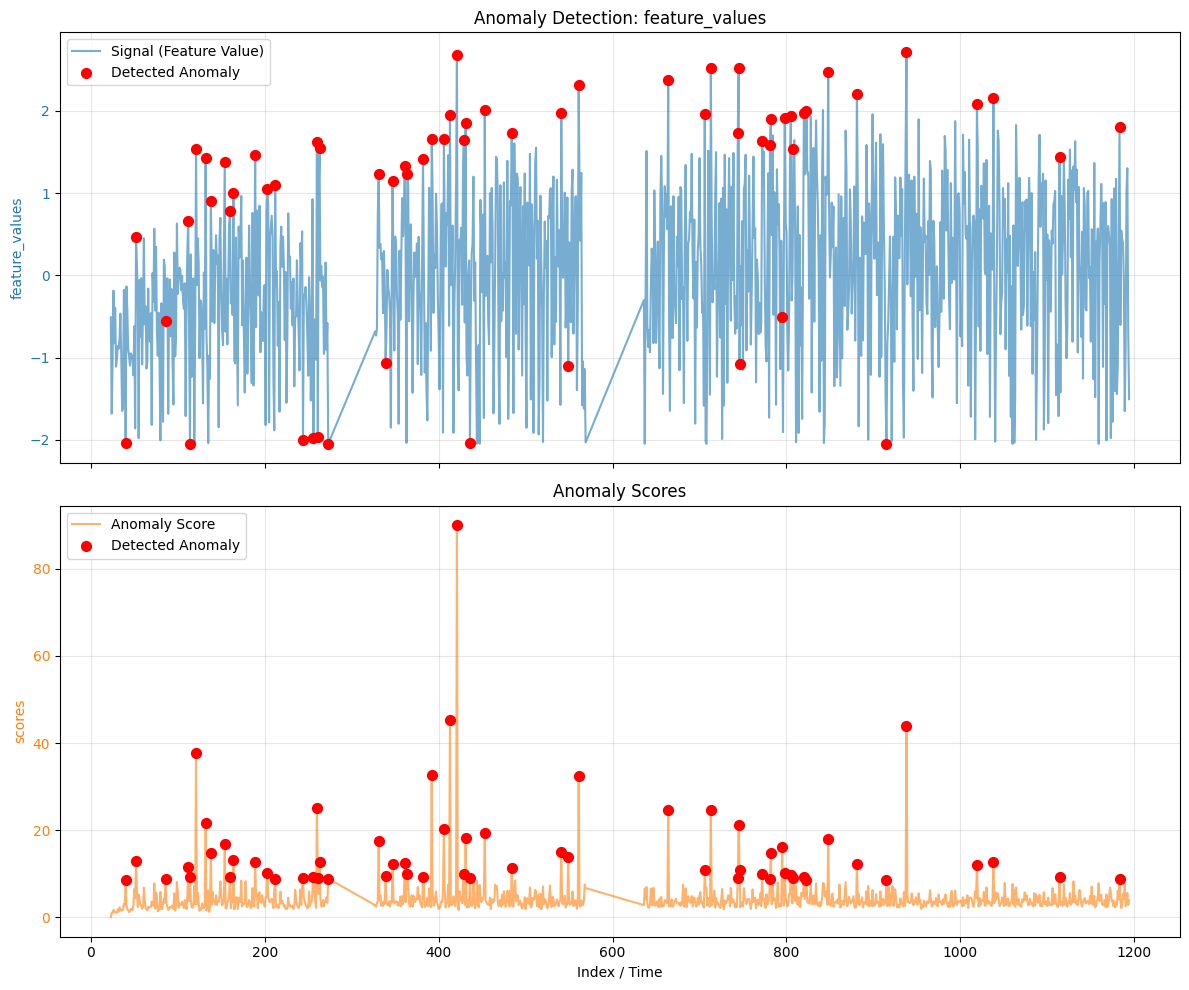

In [62]:
plot_anomalies(df=anomaly_scores)

In [69]:
## Features that we have to work on 
{'what_you_see': ['Blinking', 'Gaze', 'Jaw', 'Smile'],
 'how_it_is_said': ['loudness', 'pitch_avg', 'pitch_var'],
 'What_is_said': ['filler%', 'pause%', 'words', 'words_rate']}

{'what_you_see': ['Blinking', 'Gaze', 'Jaw', 'Smile'],
 'how_it_is_said': ['loudness', 'pitch_avg', 'pitch_var'],
 'What_is_said': ['filler%', 'pause%', 'words', 'words_rate']}

In [1]:
print("Bad day")

Bad day
